In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [58]:
# Set up files
dir_noQuestion = 'data/vernierSixBlocksData/first_second_Runs_sixBlocks'
files_noQuestion = [f for f in os.listdir(dir_noQuestion) if f.endswith('.csv')]

dir_effortQ = 'data/vernierSixBlocksData/thirdRun_effortQ'
files_effortQ = [f for f in os.listdir(dir_effortQ) if f.endswith('.csv')]

numSubj = len(files_noQuestion) + len(files_effortQ)
print('Number of subjects: ', numSubj)

Number of subjects:  23


In [59]:
def getThresholds(mydir, files, block_end, question_blocks_bool, numRepeats = 6, block_start = 2, 
                     num_staircase_per_block = 2, num_trials_per_staircase = 35):
    
    # initialize data matrix
    numSubj = len(files)
    
    if num_staircase_per_block == 2:
        subj_left = np.full((numSubj, numRepeats), np.nan)
        subj_right = np.full((numSubj, numRepeats), np.nan)

    
    # calculate thresholds
    for subj in range(numSubj):

        # Read the CSV file
        file_path = os.path.join(mydir, files[subj])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            print(f'Warning: incomplete experiment (Subject {subj+1})')

        if question_blocks_bool:
            blocks_include = range(block_start, block_end, 2)
        else:
            blocks_include = range(block_start, block_end + 1)
            
        for b in blocks_include:  # Loop over blocks
                
            for s in range(num_staircase_per_block):  # Loop over staircases
                blockOfInterest = b
                staircase = s + 1
                staircase_name = f'{blockOfInterest}_{staircase}'
                # Filter rows based on block and staircase
                rows_staircase = mainOutput[mainOutput['staircaseName'] == staircase_name]

                # Exclusion criteria 2: number of trials sent to quest
                # Count trials sent to quest
                trial_sent = rows_staircase['trialGivenToQuest']
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                if not trial_sent_bool:
                    print(f'Warning: not enough trials (Subject {subj+1}, Block {b}, staircase {s}, {trial_sent_bool} trials)')


                # Exclusion criteria 3: questSD > 0.1
                questSD = rows_staircase['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.4
                if not small_questSD_bool:
                    print(f'Warning: large SD (Subject {subj+1}, Block {b}, staircase {s})')
                    small_questSD_bool = False


                # Process thresholds
                if complete_bool and trial_sent_bool and small_questSD_bool:
                    thresholds_raw = rows_staircase['questMeanAtEndOfTrialsLoop'].dropna().values
                    assert len(thresholds_raw) == 1, 'Error: more than 1 thresholds'

                    thresholds_raw_log = thresholds_raw[0]

                    thresholds_raw_deg = 10 ** thresholds_raw_log

                    # Assign to left and right array
                    if s == 0:
                        if question_blocks_bool:
                            subj_right[subj, b//2 - 1] = thresholds_raw_deg

                        else:
                            subj_right[subj, b - 2] = thresholds_raw_deg

                            
                    elif s == 1: 
                        if question_blocks_bool:
                            subj_left[subj, b//2 - 1] = thresholds_raw_deg

                        else:
                            subj_left[subj, b - 2] = thresholds_raw_deg
                    else:
                        print('Warning: invalide staircase number.')
                else:
                    if s == 0:
                        if question_blocks_bool:
                            subj_right[subj, b//2 - 1] = np.nan

                        else:
                            subj_right[subj, b - 2] = np.nan

                            
                    elif s == 1: 
                        if question_blocks_bool:
                            subj_left[subj, b//2 - 1] = np.nan

                        else:
                            subj_left[subj, b - 2] = np.nan
                    else:
                        print('Warning: invalide staircase number.')
                    
                        
                        
    return subj_right, subj_left
                        



In [60]:
block_end = 7
subj_right_noQ, subj_left_noQ = getThresholds(dir_noQuestion, files_noQuestion, 7, False)

In [61]:
block_start = 2
numRepeats = 6
block_end = block_start + 2 * numRepeats - 1 
subj_right_effortQ, subj_left_effortQ = getThresholds(dir_effortQ, files_effortQ, block_end, True)

## NOTE: questSDs are high for almost all participants and all thresholds. For now, I filter with a questSD threshold of 0.5. We should discuss the exclusion criteria for this task.

In [62]:
subj_right_thresholds = np.vstack((subj_right_noQ, subj_right_effortQ))
subj_left_thresholds = np.vstack((subj_left_noQ, subj_left_effortQ))

print(subj_right_thresholds)
print(subj_left_thresholds)

print('Right thresholds shape:', subj_right_thresholds.shape)
print('Left thresholds shape:', subj_left_thresholds.shape)

[[0.09572954        nan 0.05649999 0.14253013        nan 0.11434418]
 [       nan 0.06620181 0.01560935 0.1204148  0.06983768 0.22582009]
 [0.09761936 0.08638462 0.11073493 0.07758441 0.08402142 0.09577805]
 [       nan 3.29785113        nan 3.96584495 0.56955205 0.50325522]
 [0.02672005 0.0354494  0.03415006 0.01759857 0.02515156 0.03932058]
 [       nan        nan        nan        nan        nan        nan]
 [0.12271004        nan 0.07939079 0.04337368 0.05586087 0.01104113]
 [0.20962115 0.17028691 0.09047772 0.08346891 0.09448983 0.05519893]
 [0.03968385 0.02593666        nan 0.0385821  0.03130821 0.03258874]
 [0.24257103 0.10909354        nan 0.03463178 0.05911556 0.03220961]
 [6.3296487  0.09457169 0.11307973 0.05354741 0.09916085 0.04370776]
 [0.04400081 0.0329548  0.02830225 0.0173741  0.04201805        nan]
 [0.03206784 0.02086615 0.03199381 0.02232741 0.02611985 0.01185946]
 [0.05305247 0.05245388 0.04537976 0.06823628 0.05825644 0.06025323]
 [5.55001354 0.16732397 0.18690611

In [63]:
def round_sig(x, sig=1):
    return float(f"{x:.{sig-1}g}")

def plot_RL_thresholds(subj_left, subj_right, repeats = range(1, 7),
                             patch_min = 0.18, patch_max = 0.41):
 
    arr = np.geomspace(0.01, 10, num=11)
    ticks = np.array([round_sig(x, sig=2) for x in arr])

    plt.figure(figsize=(10, 6))
    # plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
    for i, row in enumerate(subj_right):
        plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
    plt.title('Right Thresholds')
    plt.xlabel('Repeats')
    plt.ylabel('Letter acuity thresholds')
    plt.legend()
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim([0.004,1.2])
    plt.yticks(ticks, labels=[f"{x}" for x in ticks], fontsize = 12)
    plt.gca().yaxis.set_minor_locator(plt.NullLocator()) 
    plt.show()

    plt.figure(figsize=(10, 6))
    # plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
    for i, row in enumerate(subj_left):
        plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
    plt.title('Left Thresholds')
    plt.xlabel('Repeats')
    plt.ylabel('Letter acuity thresholds')
    plt.legend()
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim([0.004,1.2])
    plt.yticks(ticks, labels=[f"{x}" for x in ticks], fontsize = 12)
    plt.gca().yaxis.set_minor_locator(plt.NullLocator()) 
    plt.show()


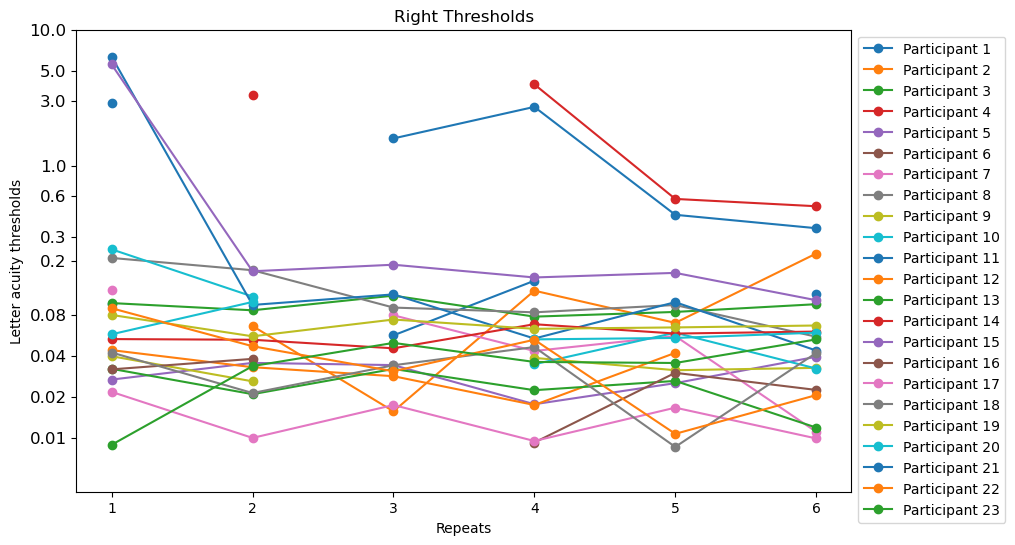

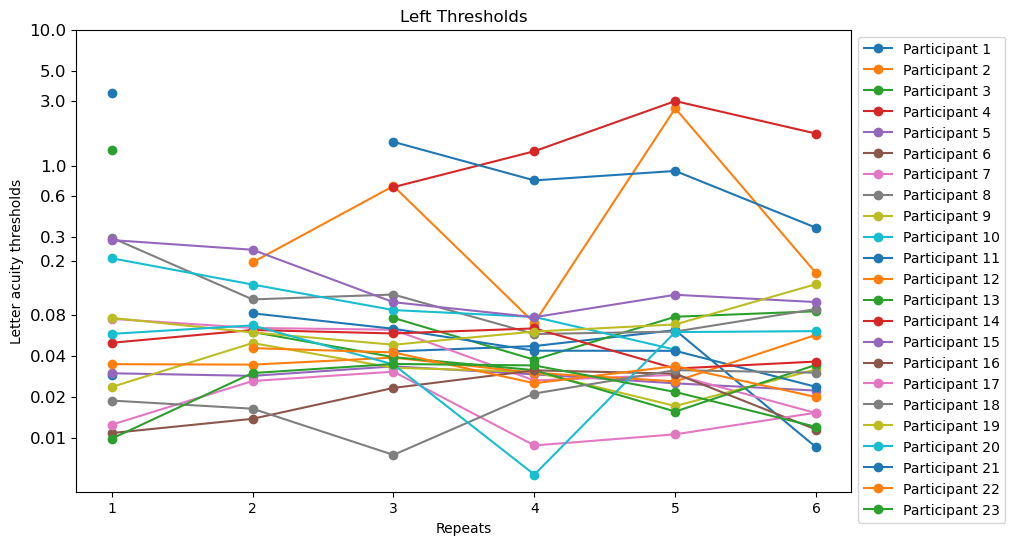

In [64]:
plot_RL_thresholds(subj_left_thresholds, subj_right_thresholds)


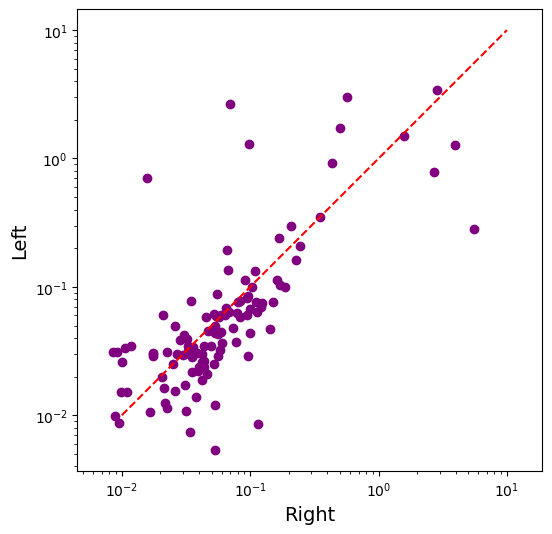

In [65]:
# Create scatter plot
plt.figure(figsize=(6, 6))  # Make the plot square
plt.scatter(subj_right_thresholds, subj_left_thresholds, color='purple')
plt.plot([0.01, 10], [0.01, 10], color='red', linestyle='--', label='y = x')  # Line y = x

# Set axes to have equal scale
plt.axis('equal')
plt.xscale('log')
plt.yscale('log')
# Add labels and legend
plt.xlabel(f'Right', fontsize = 14)
plt.ylabel(f'Left', fontsize = 14)

# Show the plot
plt.show()

In [66]:
subj_avgRL_log = (np.log10(subj_right_thresholds) + np.log10(subj_left_thresholds)) / 2

print(subj_avgRL_log)

[[-1.2787899          nan -1.30696718 -1.08639781         nan -1.50660402]
 [        nan -0.94488715 -0.97810221 -1.03797963 -0.36706718 -0.71888774]
 [-0.44754616         nan -1.03763786 -1.26869589 -1.09330392 -1.0447318 ]
 [        nan         nan         nan  0.35235325  0.11541007 -0.03111482]
 [-1.54992158 -1.49811843 -1.47134163 -1.64468225 -1.60011492 -1.52981301]
 [        nan         nan         nan         nan         nan         nan]
 [-1.01886986         nan -1.15339749 -1.47136144 -1.39579943 -1.88837801]
 [-0.60401234 -0.87609001 -0.9955548  -1.15832564 -1.12236066 -1.1560705 ]
 [-1.51463392 -1.44534428         nan -1.46488375 -1.63579299 -1.49270065]
 [-0.64789939 -0.91817375         nan -1.28643767 -1.29082047         nan]
 [        nan -1.05509904 -1.07302539 -1.31597994 -1.18266609 -1.49314874]
 [-1.4081416  -1.47268839 -1.47985907 -1.64173417 -1.4814618          nan]
 [        nan -1.45166907 -1.45144619 -1.57756274 -1.69574791 -1.69516425]
 [-1.2889529  -1.24433728

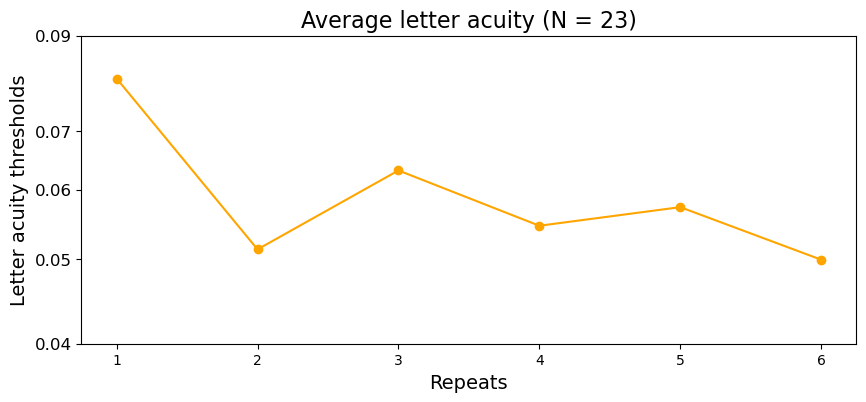

In [67]:
plt.figure(figsize=(10, 4))

plt.plot(range(1,7), 10 ** np.nanmean(subj_avgRL_log, axis = 0), marker='o', color = 'orange')
plt.title(f'Average letter acuity (N = {numSubj})', fontsize = 16)
plt.xlabel('Repeats', fontsize = 14)
plt.xticks(range(1,7))
plt.ylabel('Letter acuity thresholds', fontsize = 14)
plt.yscale('log')
plt.ylim([0.04, 0.09])

arr = np.geomspace(0.04, 0.09, num=5)
ticks = np.array([round_sig(x, sig=2) for x in arr])

plt.yticks(ticks, labels=[f"{x}" for x in ticks], fontsize = 12)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())
plt.show()

In [108]:
def plot_test_retest_scatter(data, group_X, group_Y):
    '''
    This function filters the data given the provided groupings and plots a scatter plot of test vs. retest
    It can give us an intuition of the within- and between- individual variances
    (i.e., if the within-std is large relative to the btw-std, R is low, and vice versa)
    
    Inputs:
    subj_data:        thresholds for each repeat of each individual. 
                      2D matrix with rows as individuals and columns as repeats.
    group_X, group_Y: specify which repeat(s) (i.e., columns) to include when averaging and plotting
                      for each dimension (X and Y).
                      These two arrays are lists but not np arrays.
    '''
    
    # filter data given the provided groupings
    group_X_array = np.array(group_X)
    group_Y_array = np.array(group_Y)

    data_X = data[:, group_X_array - 1]
    data_Y = data[:, group_Y_array - 1]
    
    # calculate one mean for each subject
    means_X = np.nanmean(data_X, axis = 1)
    means_Y = np.nanmean(data_Y, axis = 1)
    # Remove NaNs before calculation
    mask = ~np.isnan(means_X) & ~np.isnan(means_Y)  # Create mask for valid data
    r_value, _ = pearsonr(means_X[mask], means_Y[mask])

    # Create scatter plot
    plt.figure(figsize=(4, 4))  # Make the plot square
    plt.scatter(10 ** means_X, 10 ** means_Y, color='purple', alpha = 0.7)
    plt.plot([0.01, 1.1], [0.01, 1.1], color='red', linestyle='--', label='y = x')  # Line y = x

    # Set axes to have equal scale
    plt.axis('equal')
    plt.xscale('log')
    plt.yscale('log')

    # add ticks and format them as normal floats
    arr = np.geomspace(0.01, 1, num=5)
    ticks = np.array([round_sig(x, sig=2) for x in arr])

    plt.xticks(ticks, labels=[f"{x:.2f}" for x in ticks], fontsize = 12)
    plt.yticks(ticks, labels=[f"{x:.2f}" for x in ticks], fontsize = 12)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())
    plt.gca().yaxis.set_minor_locator(plt.NullLocator())

    # Add labels and legend
    plt.xlabel(f'Average over repeats {group_X}', fontsize = 14)
    plt.ylabel(f'Average over repeats {group_Y}', fontsize = 14)
    plt.title(f'Test vs. Retest Correlation (R = {round(r_value,2)})', fontsize = 16)

    # Show the plot
    plt.show()


/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_72547/2498704642.py:23: RuntimeWarning: Mean of empty slice
  means_X = np.nanmean(data_X, axis = 1)
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_72547/2498704642.py:24: RuntimeWarning: Mean of empty slice
  means_Y = np.nanmean(data_Y, axis = 1)


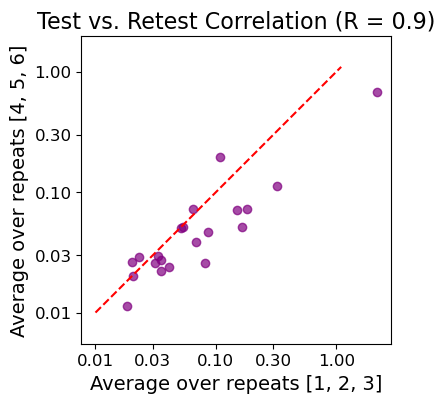

In [109]:
# learning
plot_test_retest_scatter(subj_avgRL_log, [1,2,3], [4,5,6])